One of my favorite sources of post inspiration is reading about interesting probability/prior distributions and implementing them in [PyMC](https://www.pymc.io/welcome.html) for my own edification ([1](https://austinrochford.com/posts/r2-priors-pymc.html) [2](https://austinrochford.com/posts/2021-08-11-splines-hetero.html) [3](https://austinrochford.com/posts/2021-05-29-horseshoe-pymc3.html) [4](https://austinrochford.com/posts/2018-11-10-monotonic-predictors.html)).  I had just such an experience this week reading [_The Box-Cox power exponential distribution_](https://blog.djnavarro.net/posts/2025-08-02_box-cox-power-exponential/) written by [Danielle Navarro](https://djnavarro.net/).  This post introduces two distributions motivated by the classic [Box-Cox transform](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation), the Box-Cox normal distribution for modeling location, scale, and [skewness](https://en.wikipedia.org/wiki/Skewness) and the Box-Cox power exponential (BCPE) distribution for modeling location, scale, skewness, and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis).  This post will focus on the implementation of and inference for the latter distribution in PyMC.  For motivation and further details, please refer to the excellent original post.

First we make the necessary Python imports and do some light configuration.

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
import arviz as az
from matplotlib import pyplot as plt, rcParams
import numpy as np
import nutpie
from pandas import read_sas
import polars as pl
import pymc as pm
from pytensor import tensor as pt
import seaborn as sns
from seaborn import objects as so

In [4]:
rcParams["figure.figsize"] = (8, 6)

sns.set(color_codes=True)

## Load the data

We follow the original post by using weight data from the [2021-2023 National Health and Nutrition Examination Survey](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?Cycle=2021-2023) (NHANES).

In [5]:
DATA_DIR = Path("./data/")

BMX_PATH = DATA_DIR / "BMX_L.xpt"
DEMO_PATH = DATA_DIR / "DEMO_L.xpt"

### Demographic data

First we load and transform the necessary demographic data for each survey subject.

In [6]:
DEMO_COLS = ["SEQN", "RIAGENDR", "RIDAGEYR"]

In [7]:
GENDER = pl.Enum(["Female", "Male"])

In [8]:
def gender_to_enum(col):
    return (
        pl.when(col == 1)
        .then(pl.lit("Male"))
        .when(col == 2)
        .then(pl.lit("Female"))
        .otherwise(pl.lit("Unknown"))
        .cast(GENDER)
        .alias("gender")
    )

In [9]:
cast_SEQN = pl.col("SEQN").cast(pl.Int64)

In [10]:
demo_df = (
    pl.from_pandas(read_sas(DEMO_PATH))
    .select(DEMO_COLS)
    .with_columns(cast_SEQN, gender_to_enum(pl.col("RIAGENDR")))
    .drop("RIAGENDR")
    .rename({"RIDAGEYR": "age", "SEQN": "seqn"})
)

In [11]:
demo_df

seqn,age,gender
i64,f64,enum
130378,43.0,"""Male"""
130379,66.0,"""Male"""
130380,44.0,"""Female"""
130381,5.0,"""Female"""
130382,2.0,"""Male"""
…,…,…
142306,9.0,"""Male"""
142307,49.0,"""Female"""
142308,50.0,"""Male"""


The columns are

* `seqn` - a unique identifier for the survey subject,
* `age` - the subject's age in years, and
* `gender` - the subject's gender.

## Measurement data

Next we load and transform the necessary examination data for each survey subject.

In [12]:
BMX_COLS = ["SEQN", "BMXWT"]

In [13]:
bmx_df = (
    pl.from_pandas(read_sas(BMX_PATH))
    .select(BMX_COLS)
    .with_columns(cast_SEQN)
    .rename({"SEQN": "seqn", "BMXWT": "weight"})
)

In [14]:
bmx_df

seqn,weight
i64,f64
130378,86.9
130379,101.8
130380,69.4
130381,34.3
130382,13.6
…,…
142306,25.3
142307,null
142308,79.3


The columns are

* `seqn` - the same unique identifier for the survey subject and
* `weight` - the subject's weight in kilograms.

### Joint data

We join these dataframes on the unique subject identifier and remove rows with missing data.

In [15]:
full_df = demo_df.join(bmx_df, on="seqn").drop_nulls()

In [16]:
full_df

seqn,age,gender,weight
i64,f64,enum,f64
130378,43.0,"""Male""",86.9
130379,66.0,"""Male""",101.8
130380,44.0,"""Female""",69.4
130381,5.0,"""Female""",34.3
130382,2.0,"""Male""",13.6
…,…,…,…
142305,76.0,"""Female""",60.4
142306,9.0,"""Male""",25.3
142308,50.0,"""Male""",79.3


## Exploratory data analysis

Following the original post to validate that we are using the same data set, we visualize the relationship between age, weight and gender below.

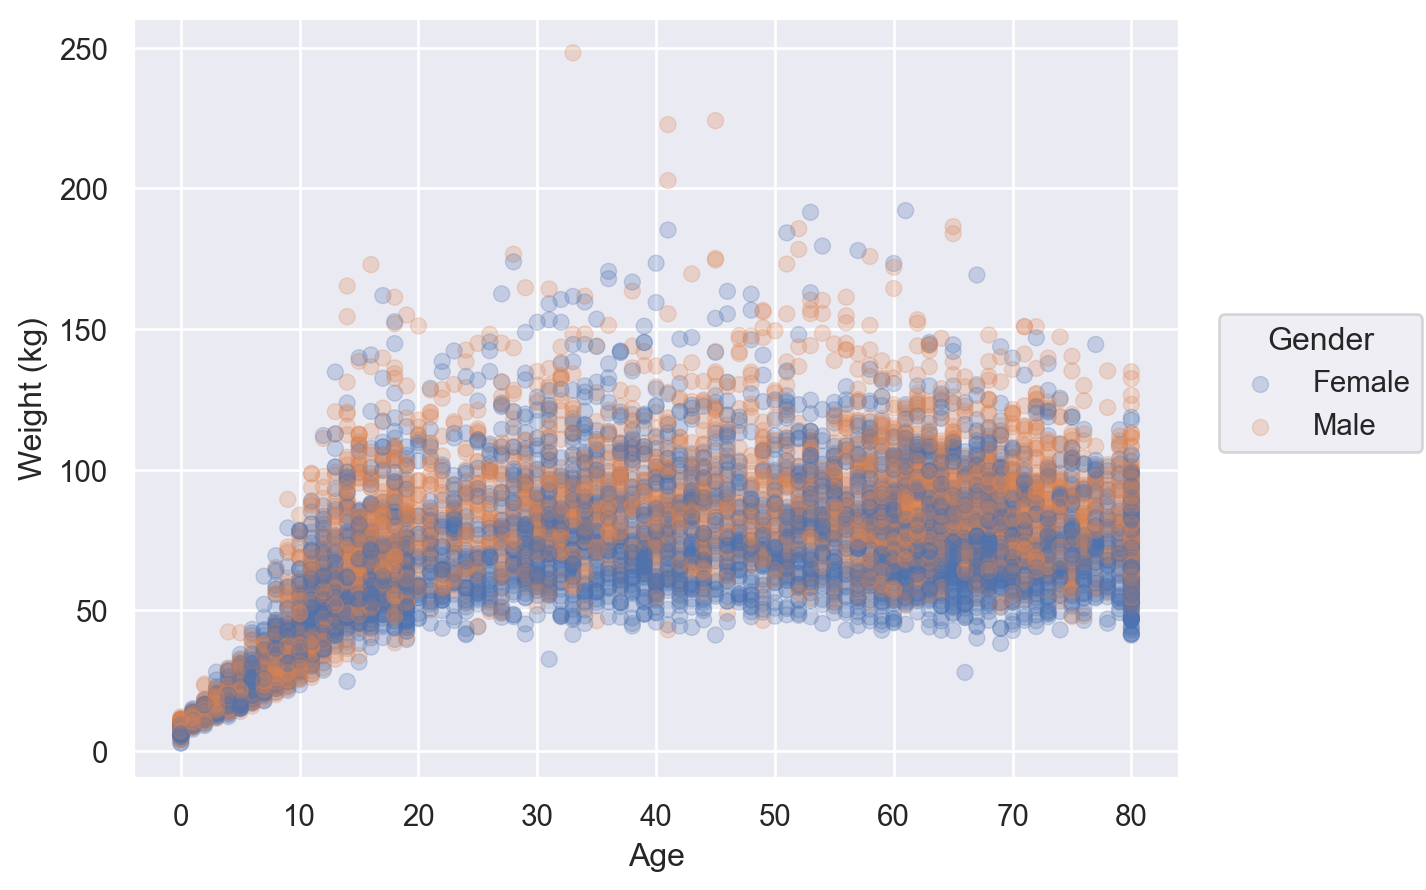

In [17]:
(
    so.Plot(full_df, x="age", y="weight", color="gender")
    .add(so.Dot(alpha=0.25))
    .scale(color=so.Nominal(order=GENDER.categories))
    .label(x="Age", y="Weight (kg)", color=str.capitalize)
)

Finally, we restrict our analysis to subjects 26 to 50 years old and visualize the distribution of weight among these subjects by gender.

In [18]:
df = full_df.filter(pl.col("age").is_between(25, 50, closed="right"))

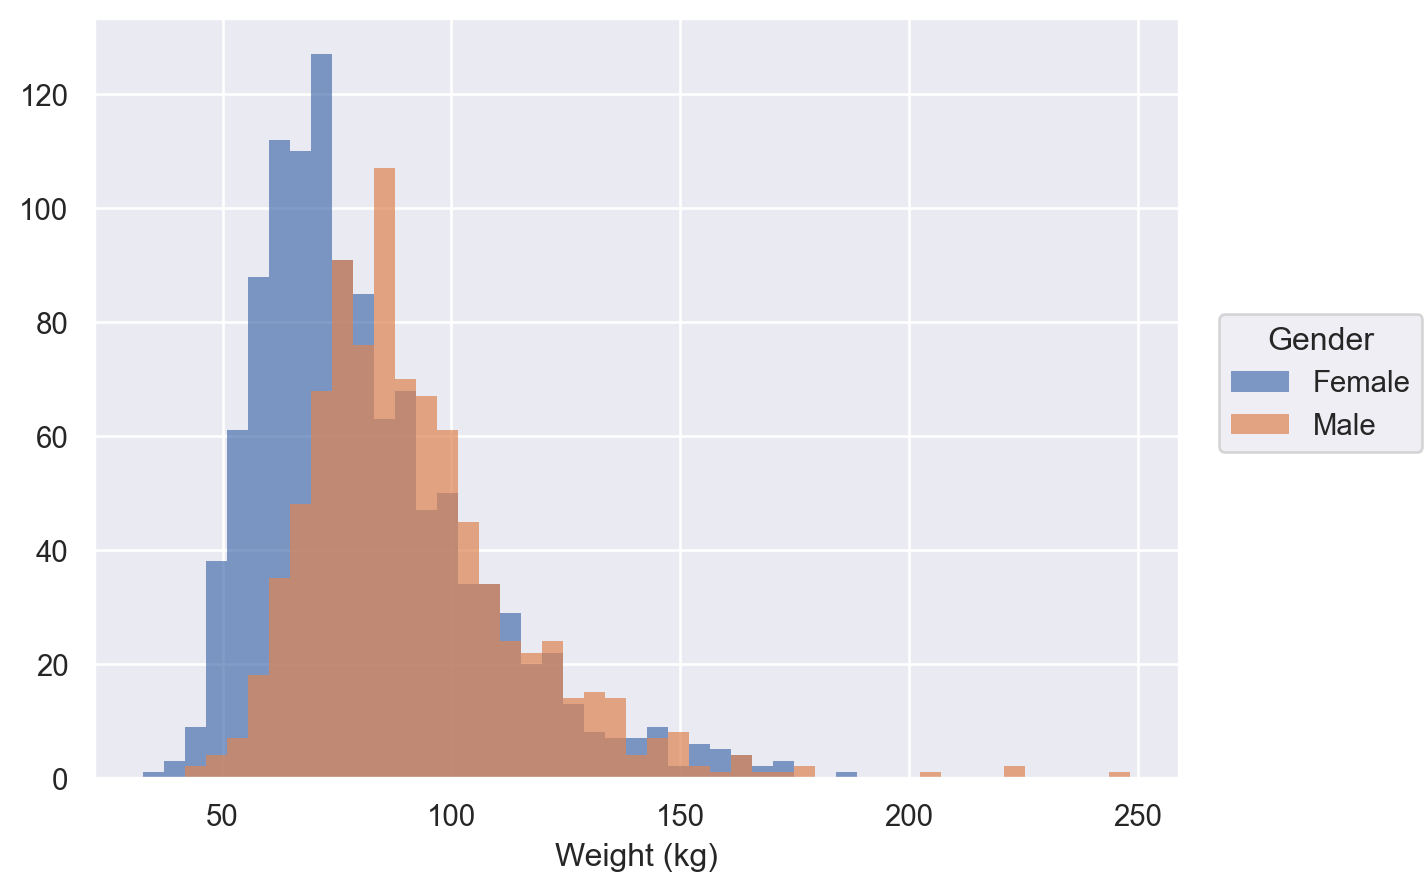

In [19]:
(
    so.Plot(
        df,
        x="weight",
        color="gender",
    )
    .add(so.Bar(edgewidth=0, width=1), so.Hist())
    .scale(color=so.Nominal(order=GENDER.categories))
    .label(x="Weight (kg)", color=str.capitalize)
)

As in the original post, we see that these distributions are decidely non-normal, possessing both interesting skewness and kurtosis, requiring a distribution with the flexibility of the BCPE to model accurately.

## Modeling

Per the original post, the BCPE distribution has four parameters, $\mu \in (-\infty, \infty)$, $\sigma > 0$, $\nu \in (-\infty, \infty)$, and $\tau > 0$.  Its probability density is

$$f(y\ |\ \mu, \sigma, \nu, \tau) = \frac{y^{\nu - 1}}{\mu^{\nu} \cdot \sigma} \cdot f(z\ |\ \tau).$$

Here $z$ is related to $y$ by a transformation reminiscient of Box-Cox,

$$z = \begin{cases}
    \frac{1}{\sigma \cdot \nu} \cdot \left(\left(\frac{y}{\mu}\right)^{\nu} - 1\right) & \textrm{if } \nu \neq 0 \\
    \frac{1}{\sigma} \cdot \log\left(\frac{y}{\mu}\right) & \textrm{if } \nu = 0
\end{cases}.$$

The probability density of $z$ is

$$f(z\ |\ \tau) = \frac{\tau}{c \cdot 2^{1 + \tau^{-1}} \cdot \Gamma(\tau^{-1})} \cdot \exp\left(-\frac{1}{2} \cdot \left(\frac{|z|}{c}\right)^{\tau}\right).$$

This distribution has normalizing constant

$$c = \sqrt{\frac{\Gamma(\tau^{-1})}{4^{\tau^{-1}} \cdot \Gamma(3 \tau^{-1})}}.$$

To implement the BCPE distribution in PyMC, we will need to calculate the log probability density $\log f(y\ |\ \mu, \sigma, \nu, \tau)$.  To do so, first we note that the log of the normalizing constant $c$ is

$$\log c = \frac{1}{2} \cdot \left(\log \Gamma(\tau^{-1}) - \tau^{-1} \cdot \log 4 - \log \Gamma(3 \tau^{-1})\right),$$

and implement this calculation as a Python function.

In [20]:
def log_c(τ):
    return 0.5 * (
        pt.special.gammaln(τ**-1) - τ**-1 * np.log(4) - pt.special.gammaln(3 * τ**-1)
    )

Next we implement the transformation of $y$ into $z$ as a Python function.

In [21]:
def z(y, μ, σ, ν):
    # ν_ avoids dividing by zero in the third argument to switch when ν is zero
    # it is necessary because both alternatives are evaluated regardless of the
    # value of ν
    ν_ = pt.switch(pt.eq(ν, 0), 1, ν)

    return pt.switch(
        pt.eq(ν, 0), 1 / σ * (pt.log(y) - pt.log(μ)), 1 / (σ * ν_) * ((y / μ) ** ν - 1)
    )

Next we calculate the log density of $z$,

$$\log f(z\ |\ \tau) = \log \tau - \log c - (1 + \tau^{-1}) \cdot \log 2 - \log \Gamma(\tau^{-1}) - \frac{1}{2} \cdot \left(\frac{|z|}{c}\right)^{\tau},$$

and implement it as a Python function.

In [22]:
def log_fz(y, μ, σ, ν, τ):
    log_c_ = log_c(τ)
    z_ = z(y, μ, σ, ν)

    return (
        pt.log(τ)
        - log_c_
        - (1 + τ**-1) * np.log(2)
        - pt.special.gammaln(τ**-1)
        - 0.5 * (pt.abs(z_) / pt.exp(log_c_)) ** τ
    )

Finally we calculate the log probability density of $y$,

$$\log f(y\ |\ \mu, \sigma, \nu, \tau) = (\nu - 1) \cdot \log y - \nu \cdot \log \mu - \log \sigma + \log f(z\ |\ \tau),$$

and implement it as a Python function.

In [23]:
def bcpe_logp(y, μ, σ, ν, τ):
    return (ν - 1) * pt.log(y) - ν * pt.log(μ) - pt.log(σ) + log_fz(y, μ, σ, ν, τ)


def bcpe_density(y, μ, σ, ν, τ):
    return pt.exp(bcpe_logp(y, μ, σ, ν, τ)).eval()

Following the original post, we now set $\mu = 10$ and $\sigma = 10^{-1}$ and visualize the BCPE probability density function for combinations of $\nu \in \{-9, -3, 0, 3, 0\}$ and $\tau \in \{1, 2, 4, 16\}$.

In [24]:
PLOT_NU = np.array([-9, -3, 0, 3, 9], dtype=np.float64)
PLOT_TAU = np.array([1, 2, 4, 16], dtype=np.float64)

In [25]:
y = np.linspace(6, 14, 100)

In [26]:
grid_y, grid_ν, grid_τ = np.meshgrid(y, PLOT_NU, PLOT_TAU, indexing="ij")

grid_fy = bcpe_density(grid_y, 10, 0.1, grid_ν, grid_τ)

In [27]:
grid_df = pl.DataFrame(
    {
        "ν": grid_ν.ravel(),
        "τ": grid_τ.ravel(),
        "y": grid_y.ravel(),
        "density": grid_fy.ravel(),
    }
)

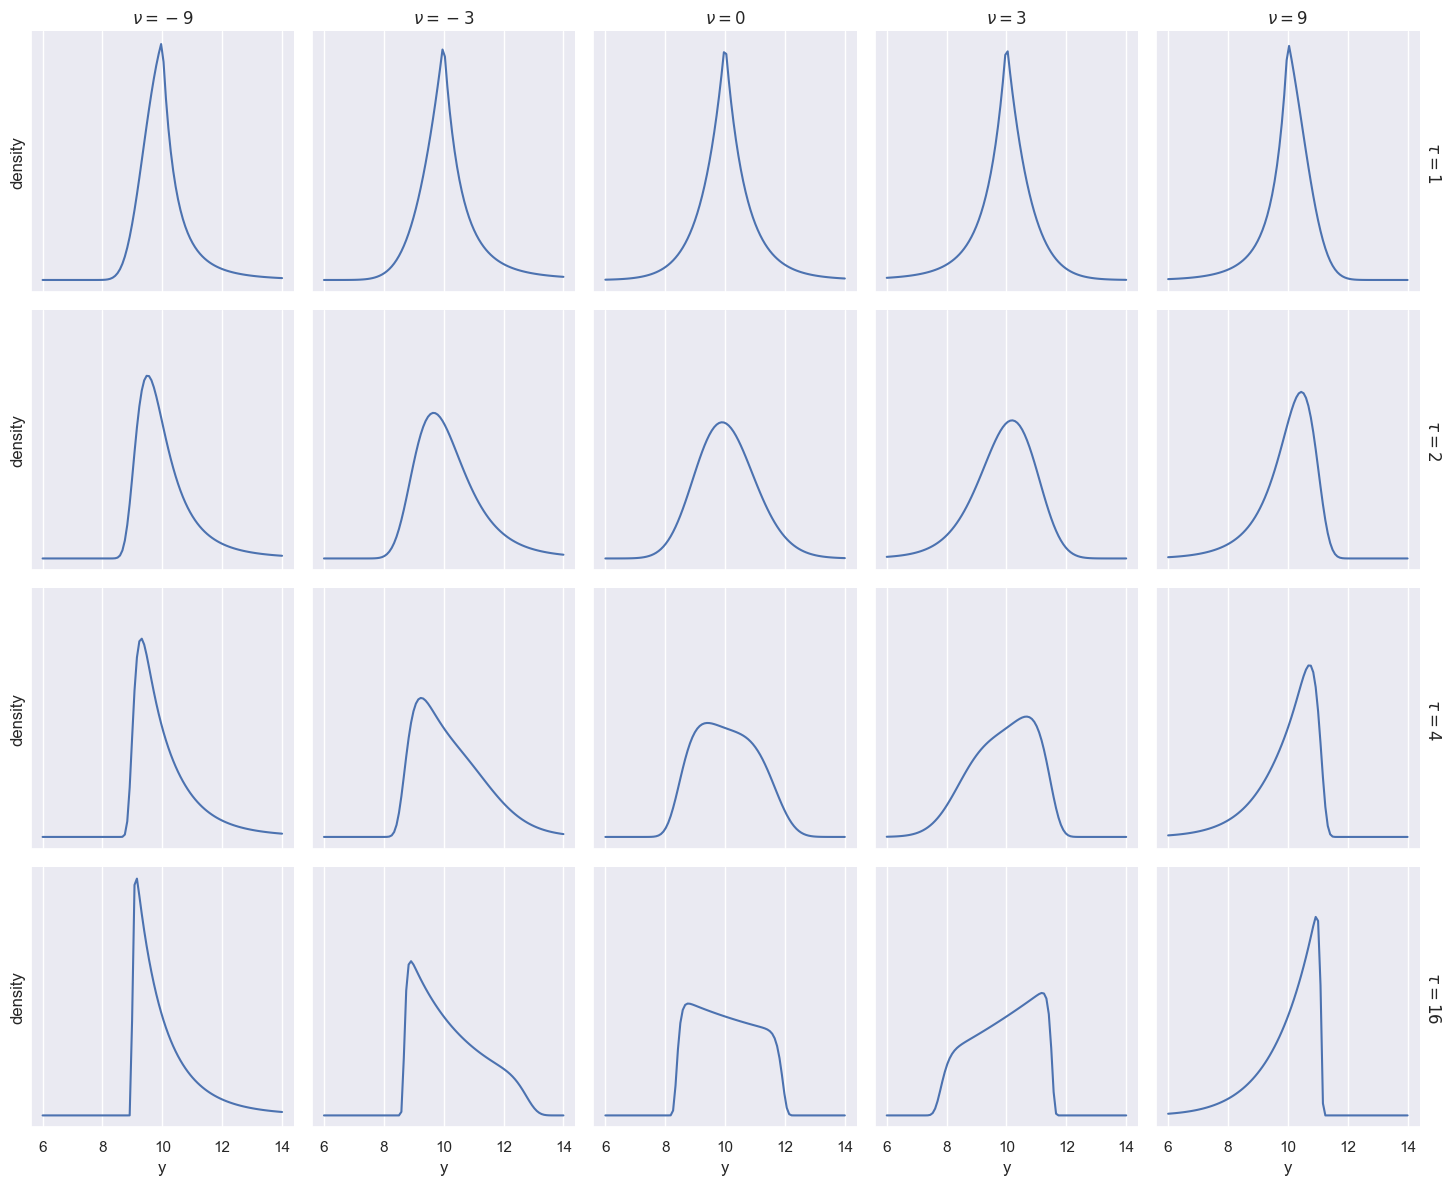

In [28]:
grid = sns.FacetGrid(grid_df, col="ν", row="τ", margin_titles=True)
grid.map(plt.plot, "y", "density")
grid.set_titles(
    row_template="$\\tau = {row_name:.0f}$", col_template="$\\nu = {col_name:.0f}$"
)

for (ax, *_) in grid.axes:
    ax.set_yticks([])

We see that these distributions are quite flexible and result in a wide variety of shapes.

## Modeling

We now proceed to construct a model of weight as a BCPE distribution in PyMC and perform inference.

First we construct a data container that will let us reuse the same model to infer the distribution of weight for both men and women.  As in the original post, we model men's weight first.

In [29]:
def get_gender_weights(df, gender):
    return df.filter(pl.col("gender") == gender).select("weight").to_numpy()

In [30]:
with pm.Model() as model:
    weight = pm.Data("weight", get_gender_weights(df, "Male"))

Next we use the following priors on the paramters of the BCPE distribution of weight.

$$
\begin{align}
    \mu & \sim N(\bar{w}, 5^2) \\
    \sigma & \sim \text{Half-}N(2.5^2) \\
    \nu & \sim N(0, 5^2) \\
    \tau & \sim \text{Half-}N(2.5^2)
\end{align}
$$

Here $\bar{w}$ is the mean of the observed weights, making this an [empirical Bayesian model](https://en.wikipedia.org/wiki/Empirical_Bayes_method).

In [31]:
with model:
    μ = pm.Normal("μ", weight.mean(), 5)
    σ = pm.HalfNormal("σ", 2.5)
    ν = pm.Normal("ν", 0, 5)
    τ = pm.HalfNormal("τ", 2.5)

Finally we use PyMC's [`CustomDist`](https://www.pymc.io/projects/docs/en/v5.9.2/api/distributions/generated/pymc.CustomDist.html) to add a BCPE likelihood for the observed weights.

In [32]:
with model:
    pm.CustomDist(
        "obs",
        μ,
        σ,
        ν,
        τ,
        logp=bcpe_logp,
        observed=weight,
    )

We now sample from the model's posterior distribution.

In [33]:
SEED = 123456789  # for reproducibility

SAMPLE_KWARGS = {"seed": SEED, "cores": 8}

In [34]:
male_trace = nutpie.sample(nutpie.compile_pymc_model(model), **SAMPLE_KWARGS)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1400,0,0.96,7
,1400,0,0.96,7
,1400,0,0.91,3
,1400,0,0.99,3
,1400,0,0.95,3
,1400,0,0.96,7


The [Gelman-Rubin statistics](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic) show no cause for concern.

In [35]:
az.rhat(male_trace)

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    μ        float64 8B 1.001
    σ_log__  float64 8B 1.001
    ν        float64 8B 1.001
    τ_log__  float64 8B 1.001
    σ        float64 8B 1.001
    τ        float64 8B 1.001

We now compare the [maximum likelihood estimates](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE) of the parameters for men from the original post to their posterior distributions from our model.

In [36]:
REF_VALS = pl.DataFrame(
    {
        "var_name": ["μ", "σ", "ν", "τ"],
        "Female": [76.4064873, 0.2699057, -0.5469284, 2.3326601],
        "Male": [87.6094265, 0.2319320, -0.5234904, 1.6945917],
    }
)

In [37]:
def get_ref_val_dict(gender):
    return {
        var_name: [{"ref_val": val[0][0]}]
        for var_name, val in REF_VALS["var_name", gender]
        .rows_by_key("var_name")
        .items()
    }

In [38]:
PLOT_VARS = ["μ", "σ", "ν", "τ"]

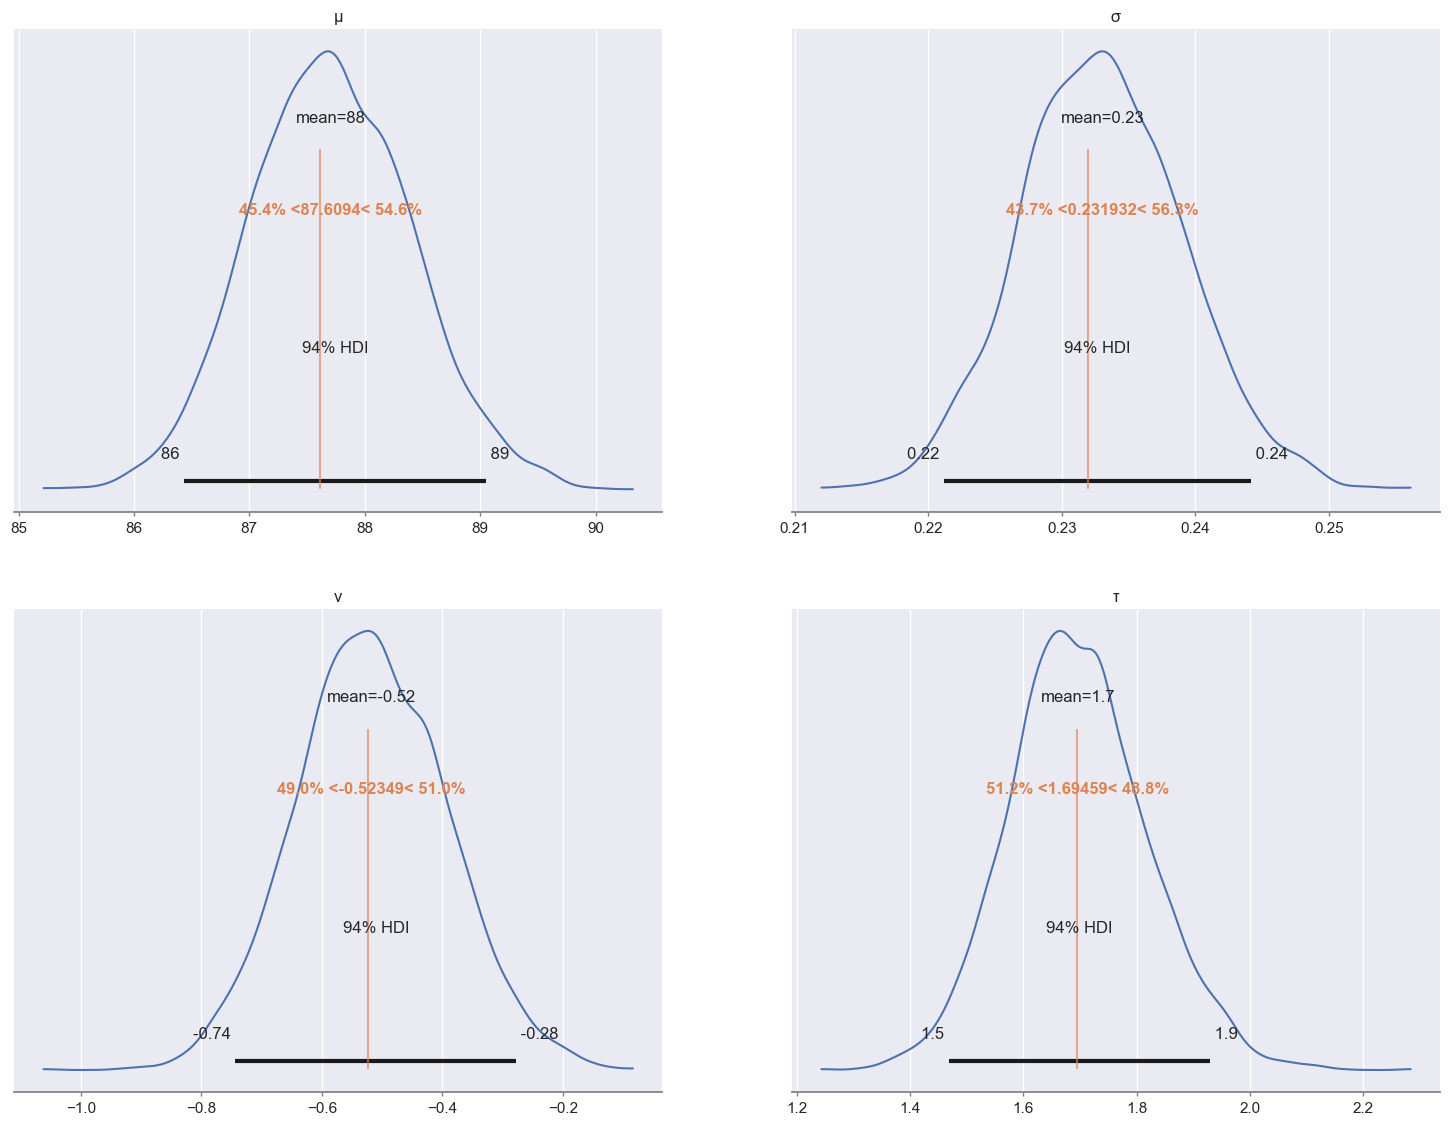

In [39]:
az.plot_posterior(
    male_trace, var_names=PLOT_VARS, grid=(2, 2), ref_val=get_ref_val_dict("Male")
);

We see that the maximum likelihood estimates are quite close to the posterior expected values and medians for each parameter.

Below we plot the BCPE distribution with parameters equal to their posterior expected values.

In [40]:
def get_posterior_ev(trace, vars_=PLOT_VARS):
    return trace.posterior[vars_].mean().to_array().to_numpy()

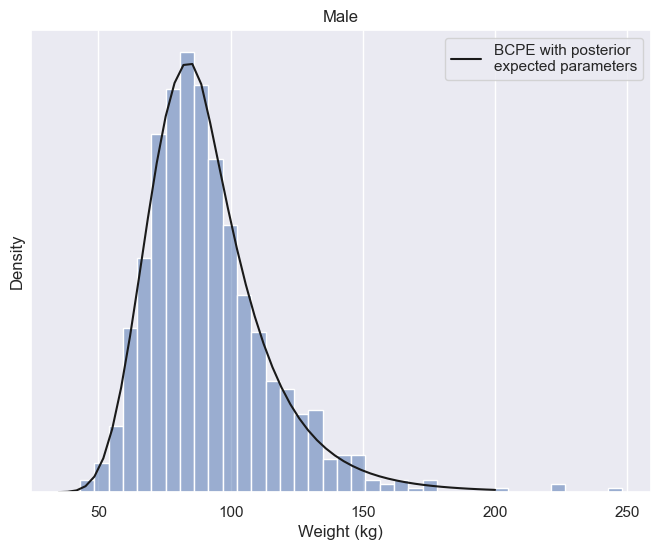

In [41]:
ax = sns.histplot(get_gender_weights(df, "Male"), stat="density", legend=False)

plot_weight = np.linspace(35, 200)
ax.plot(
    plot_weight,
    bcpe_density(plot_weight, *get_posterior_ev(male_trace)),
    c="k",
    label="BCPE with posterior\nexpected parameters",
)

ax.set_xlabel("Weight (kg)")
ax.set_yticks([])
ax.set_title("Male")
ax.legend();

As in the original post, we see strong agreement between the BCPE density and the histogram estimator.

We now use the data continer to repeat this analysis for women's weights.

In [42]:
with model:
    pm.set_data({"weight": get_gender_weights(df, "Female")})

In [43]:
female_trace = nutpie.sample(nutpie.compile_pymc_model(model), **SAMPLE_KWARGS)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1400,0,0.92,3
,1400,0,0.93,3
,1400,0,0.93,3
,1400,0,0.86,3
,1400,0,0.94,3
,1400,0,0.94,3


In [44]:
az.rhat(female_trace)

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    μ        float64 8B 1.0
    σ_log__  float64 8B 1.0
    ν        float64 8B 1.0
    τ_log__  float64 8B 1.0
    σ        float64 8B 1.0
    τ        float64 8B 1.0

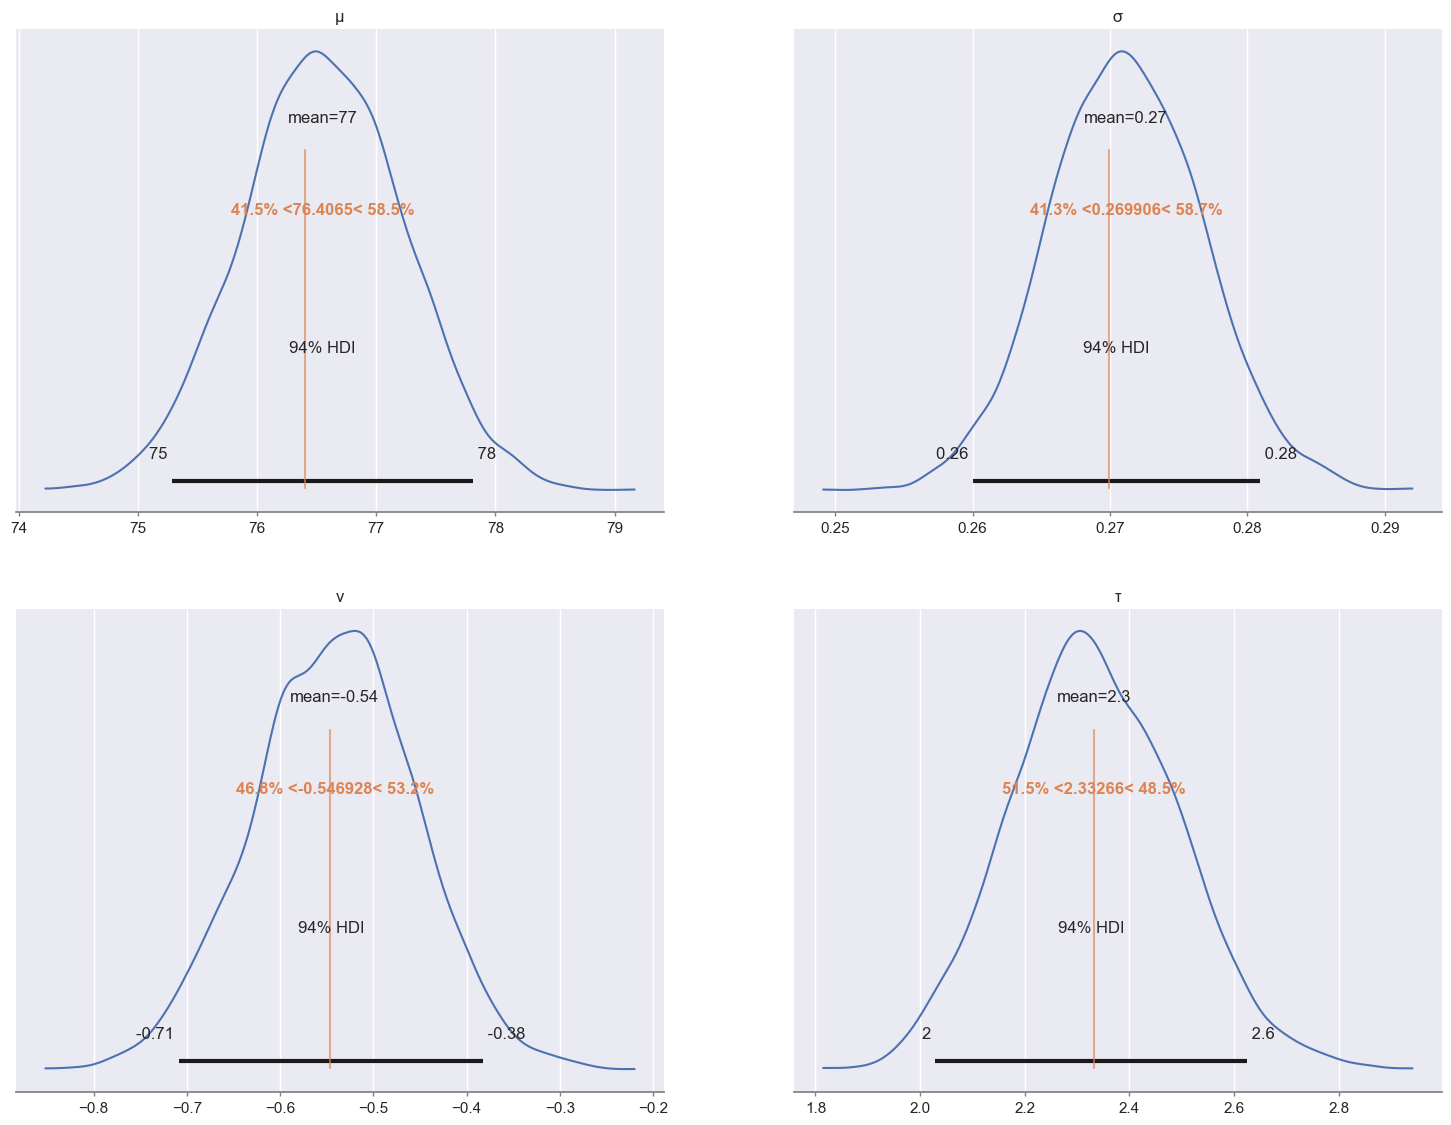

In [45]:
az.plot_posterior(
    female_trace, var_names=PLOT_VARS, grid=(2, 2), ref_val=get_ref_val_dict("Female")
);

Again we see that the maximum likelihood estimates are quite close to the posterior expected values and medians for each parameter.

Again we plot the BCPE distribution with parameters equal to their posterior expected values, and see solid agreement with the histogram estimates.

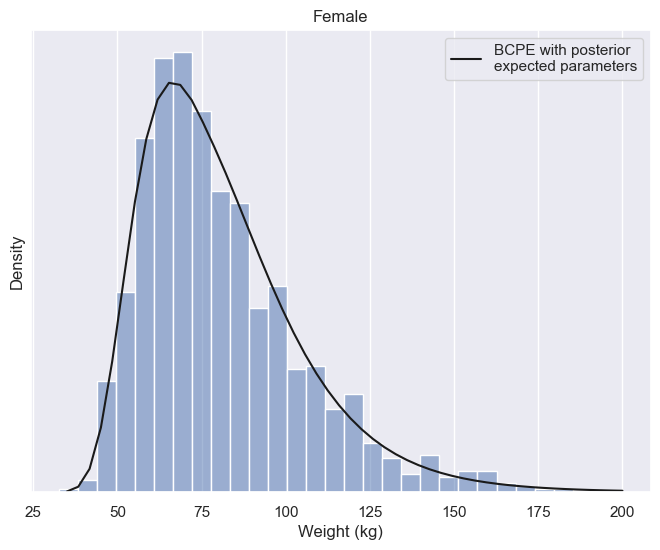

In [46]:
ax = sns.histplot(get_gender_weights(df, "Female"), stat="density", legend=False)

plot_weight = np.linspace(35, 200)
ax.plot(
    plot_weight,
    bcpe_density(plot_weight, *get_posterior_ev(female_trace)),
    c="k",
    label="BCPE with posterior\nexpected parameters",
)

ax.set_xlabel("Weight (kg)")
ax.set_yticks([])
ax.set_title("Female")
ax.legend();

My sincere thanks to Danielle Navarro for the interesting post that inspired this one.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/8853faec5fb74409522bb4fc6f34128f).

In [47]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sat Dec 13 2025

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

nutpie    : 0.15.2
numpy     : 2.0.2
arviz     : 0.20.0
matplotlib: 3.9.2
seaborn   : 0.13.2
polars    : 1.36.1
pytensor  : 2.31.7
pandas    : 2.2.3
pymc      : 5.25.1

